# Validating and Importing User-Item-Interaction Data <a class="anchor" id="top"></a>

In this notebook, you will choose a dataset and prepare it for use with Amazon Personalize.

1. [Introduction](#intro)
1. [Choose a dataset or data source](#source)
1. [Configure Amazon Personalize](#configure_personalize)
1. [Create dataset groups and the interactions dataset](#group_dataset)
1. [Configure an S3 bucket and an IAM role](#bucket_role)
1. [Import the interactions data](#import)

## Introduction <a class="anchor" id="intro"></a>

For the most part, the algorithms in Amazon Personalize (called recipes) look to solve different tasks, explained here:

1. **User Personalization** - New release that supports ALL HRNN workflows / user personalization needs, it will be what we use here.
1. **HRNN & HRNN-Metadata** - Recommends items based on previous user interactions with items.
1. **HRNN-Coldstart** - Recommends new items for which interaction data is not yet available.
1. **Personalized-Ranking** - Takes a collection of items and then orders them in probable order of interest using an HRNN-like approach.
1. **SIMS (Similar Items)** - Given one item, recommends other items also interacted with by users.
1. **Popularity-Count** - Recommends the most popular items, if HRNN or HRNN-Metadata do not have an answer - this is returned by default.

No matter the use case, the algorithms all share a base of learning on user-item-interaction data which is defined by 3 core attributes:

1. **UserID** - The user who interacted
1. **ItemID** - The item the user interacted with
1. **Timestamp** - The time at which the interaction occurred

We also support event types and event values defined by:

1. **Event Type** - Categorical label of an event (browse, purchased, rated, etc).
1. **Event Value** - A value corresponding to the event type that occurred. Generally speaking, we look for normalized values between 0 and 1 over the event types. For example, if there are three phases to complete a transaction (clicked, added-to-cart, and purchased), then there would be an event_value for each phase as 0.33, 0.66, and 1.0 respectfully.

The event type and event value fields are additional data which can be used to filter the data sent for training the personalization model. In this particular exercise we will not have an event type or event value. 

## Choose a dataset or data source <a class="anchor" id="source"></a>
[Back to top](#top)

As we mentioned, the user-item-iteraction data is key for getting started with the service. This means we need to look for use cases that generate that kind of data, a few common examples are:

1. Video-on-demand applications
1. E-commerce platforms
1. Social media aggregators / platforms

There are a few guidelines for scoping a problem suitable for Personalize. We recommend the values below as a starting point, although the [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html) lie a little lower.

* Authenticated users
* At least 50 unique users
* At least 100 unique items
* At least 2 dozen interactions for each user 

Most of the time this is easily attainable, and if you are low in one category, you can often make up for it by having a larger number in another category.

Generally speaking your data will not arrive in a perfect form for Personalize, and will take some modification to be structured correctly. This notebook looks to guide you through all of that. 


#### Open and Explore the Simulated Retail Interactions Dataset

In [1]:
# Import Dependencies

import boto3
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import csv
import sys
import botocore
import uuid
from collections import defaultdict
import random
import numpy as np
import yaml

from packaging import version
from botocore.exceptions import ClientError
from pathlib import Path

%matplotlib inline

# Setup Clients

personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
personalize_events = boto3.client('personalize-events')

# We will upload our training data in these files:
raw_items_filename = "../../automation/ml_ops/domain/Retail/data/Items/items.csv"                # Do Not Change
raw_users_filename = "../../automation/ml_ops/domain/Retail/data/Users/users.csv"                # Do Not Change
raw_interactions_filename = "../../automation/ml_ops/domain/Retail/data/Interactions/interactions.csv"  # Do Not Change
items_filename = "items.csv"                # Do Not Change
users_filename = "users.csv"                # Do Not Change
interactions_filename = "interactions.csv"  # Do Not Change


First let us see a few lines of the raw CSV data:

- An EVENT_TYPE column which can be used to train different Personalize campaigns and also to filter on recommendations.
- The custom DISCOUNT column which is a contextual metadata field, that Personalize reranking and user recommendation campaigns can take into account to guess on the best next product.

In [2]:
interactions_df = pd.read_csv(raw_interactions_filename)
interactions_df.head()

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP,DISCOUNT
0,1def0093-96b2-4cc4-a022-071941f75b92,3156,ProductViewed,1591803788,No
1,1def0093-96b2-4cc4-a022-071941f75b92,3156,ProductViewed,1591803788,No
2,4df77d59-732e-4194-b9aa-7ad3878345e7,332,ProductViewed,1591803812,Yes
3,4df77d59-732e-4194-b9aa-7ad3878345e7,332,ProductViewed,1591803812,Yes
4,31b83eb4-bd8a-4b5a-87ff-f52abe6aa1f4,3981,ProductViewed,1591803830,Yes


Chart the counts of each `EVENT_TYPE` generated for the interactions dataset. We're simulating a site where visitors heavily view/browse products and to a lesser degree add products to their cart and checkout.

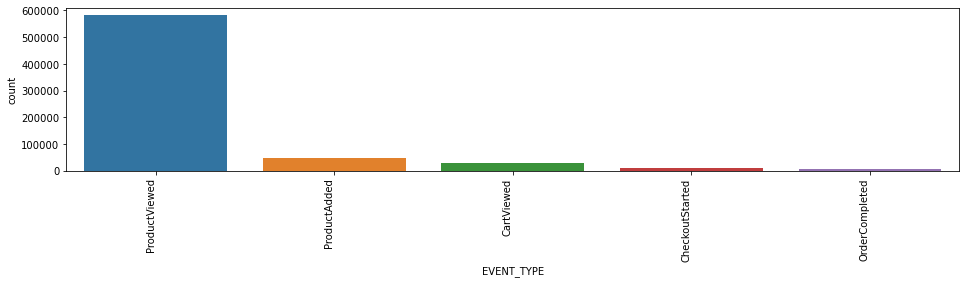

In [3]:
categorical_attributes = interactions_df.select_dtypes(include = ['object'])

plt.figure(figsize=(16,3))
chart = sns.countplot(data = categorical_attributes, x = 'EVENT_TYPE')
plt.xticks(rotation=90, horizontalalignment='right')
plt.show()


#### Explore the Users Dataset

In [4]:
users_df = pd.read_csv(raw_users_filename)
pd.set_option('display.max_rows', 5)

users_df.head()

,USER_ID,AGE,GENDER
0,1,31,M
1,2,58,F
2,3,43,M
3,4,38,M
4,5,24,M


We can also leverage some user metadata to get some additional information about our users.

In [5]:
user_metadata_file_name = '../../automation/ml_ops/domain/Retail/metadata/Users/users.json'
zipped_file_name = user_metadata_file_name+'.gz'

# this will delete the zipped file. -k is not supported with the current version of gzip on this instance.
!gzip -d $zipped_file_name

user_metadata_df = pd.read_json (user_metadata_file_name)
user_metadata_df

,id,gender,first_name,last_name,email,age,name,username,persona,discount_persona,traits,platforms,addresses
0,1,M,Mark,Johnson,mark.johnson@example.com,31,Mark Johnson,user1,furniture_homedecor_housewares,lower_priced_products,{},{'ios': {'anonymous_id': '0822e8f3-6c03-4199-9...,"[{'first_name': 'Mark', 'last_name': 'Johnson'..."
1,2,F,Kristen,Calderon,kristen.calderon@example.com,58,Kristen Calderon,user2,tools_housewares_apparel,discount_indifferent,{},{'ios': {'anonymous_id': 'fc377a4c-4a15-444d-8...,"[{'first_name': 'Kristen', 'last_name': 'Calde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,5999,F,Samantha,Reed,samantha.reed@example.com,34,Samantha Reed,user5999,electronics_outdoors_footwear,all_discounts,{},{'ios': {'anonymous_id': '8f686c00-9f03-46b4-8...,"[{'first_name': 'Samantha', 'last_name': 'Reed..."
5999,6000,F,Shannon,Martinez,shannon.martinez@example.com,24,Shannon Martinez,user6000,books_apparel_homedecor,discount_indifferent,{},{'ios': {'anonymous_id': '029ec3f5-d592-46c3-8...,"[{'first_name': 'Shannon', 'last_name': 'Marti..."


In [6]:
# zipping the metadata file
!gzip $user_metadata_file_name

#### Explore the Items Dataset

In [7]:
products_df = pd.read_csv(raw_items_filename)
pd.set_option('display.max_rows', 5)

products_df.head()

,ITEM_ID,CATEGORY,STYLE
0,6579c22f-be2b-444c-a52b-0116dd82df6c,accessories,backpack
1,2e852905-c6f4-47db-802c-654013571922,accessories,backpack
2,4ec7ff5c-f70f-4984-b6c4-c7ef37cc0c09,accessories,backpack
3,7977f680-2cf7-457d-8f4d-afa0aa168cb9,accessories,backpack
4,b5649d7c-4651-458d-a07f-912f253784ce,accessories,backpack


We are going to load some metadata and create an auxiliary method to make the products more readable.

In [8]:
# load the item meta data
item_metadata_file_name = '../../automation/ml_ops/domain/Retail/metadata/Items/products.yaml'
with open(item_metadata_file_name) as f:
    item_metadata_df = pd.json_normalize(yaml.load(f, Loader=yaml.FullLoader))[['id', 'name', 'category', 'style', 'featured']]

In [9]:
def get_item_name_from_id ( item_id ):
    item_name = item_metadata_df [item_metadata_df ['id'] == item_id]['name'].values[0]
    return item_name

Let's look at some examples

In [10]:
test = products_df.copy()

test['ITEM_NAME'] = test.apply(
      lambda row:
        get_item_name_from_id(row['ITEM_ID'] ), axis=1
  )
display(test.head())


,ITEM_ID,CATEGORY,STYLE,ITEM_NAME
0,6579c22f-be2b-444c-a52b-0116dd82df6c,accessories,backpack,Tan Backpack
1,2e852905-c6f4-47db-802c-654013571922,accessories,backpack,Pale Pink Backpack
2,4ec7ff5c-f70f-4984-b6c4-c7ef37cc0c09,accessories,backpack,Gainsboro Backpack
3,7977f680-2cf7-457d-8f4d-afa0aa168cb9,accessories,backpack,Gray Backpack
4,b5649d7c-4651-458d-a07f-912f253784ce,accessories,backpack,Peru-Orange Backpack


## Configure Amazon Personalize <a class="anchor" id="configure_personalize"></a>

Now that we've prepared our three datasets we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations.


### Create Schemas for Datasets

Amazon Personalize requires a schema for each dataset so it can map the columns in our CSVs to fields for model training. Each schema is declared in JSON using the [Apache Avro](https://avro.apache.org/) format.

Let's define and create schemas in Personalize for our datasets.

#### Items Datsaset Schema

In [11]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "CATEGORY",
            "type": "string",
            "categorical": True,
        },
        {
            "name": "STYLE",
            "type": "string",
            "categorical": True,
        }
    ],
    "version": "1.0"
}

try:
    create_schema_response = personalize.create_schema(
        name = "personalize-immersion-day-retail-schema-items",
        schema = json.dumps(items_schema)
    )
    items_schema_arn = create_schema_response['schemaArn']
    print(json.dumps(create_schema_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this schema, seemingly')
    schemas = personalize.list_schemas(maxResults=100)['schemas']
    for schema_response in schemas:
        if schema_response['name'] == "personalize-immersion-day-retail-schema-items":
            items_schema_arn = schema_response['schemaArn']
            print(f"Using existing schema: {items_schema_arn}")
    


{
  "schemaArn": "arn:aws:personalize:us-east-1:525775681955:schema/personalize-immersion-day-retail-schema-items",
  "ResponseMetadata": {
    "RequestId": "948d5cef-458e-4893-8c39-2c492e019d24",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:58:42 GMT",
      "x-amzn-requestid": "948d5cef-458e-4893-8c39-2c492e019d24",
      "content-length": "111",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Users Dataset Schema

In [12]:
users_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "AGE",
            "type": "int"
        },
        {
            "name": "GENDER",
            "type": "string",
            "categorical": True,
        }
    ],
    "version": "1.0"
}

try:
    create_schema_response = personalize.create_schema(
        name = "rpersonalize-immersion-day-retail-schema-users",
        schema = json.dumps(users_schema)
    )
    print(json.dumps(create_schema_response, indent=2))
    users_schema_arn = create_schema_response['schemaArn']
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this schema, seemingly')
    schemas = personalize.list_schemas(maxResults=100)['schemas']
    for schema_response in schemas:
        if schema_response['name'] == "personalize-immersion-day-retail-schema-users":
            users_schema_arn = schema_response['schemaArn']
            print(f"Using existing schema: {users_schema_arn}")
    



{
  "schemaArn": "arn:aws:personalize:us-east-1:525775681955:schema/rpersonalize-immersion-day-retail-schema-users",
  "ResponseMetadata": {
    "RequestId": "3273e5d5-968b-4826-b4a5-9a74378a750b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:58:42 GMT",
      "x-amzn-requestid": "3273e5d5-968b-4826-b4a5-9a74378a750b",
      "content-length": "112",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Interactions Dataset Schema

In [13]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",  # "ProductViewed", "OrderCompleted", etc.
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "DISCOUNT",  # This is the contextual metadata - "Yes" or "No".
            "type": "string",
            "categorical": True,
        },
    ],
    "version": "1.0"
}

try:
    create_schema_response = personalize.create_schema(
        name = "personalize-immersion-day-retail-schema-interactions",
        schema = json.dumps(interactions_schema)
    )
    print(json.dumps(create_schema_response, indent=2))
    interactions_schema_arn = create_schema_response['schemaArn']
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this schema, seemingly')
    schemas = personalize.list_schemas(maxResults=100)['schemas']
    for schema_response in schemas:
        if schema_response['name'] == "personalize-immersion-day-retail-schema-interactions":
            interactions_schema_arn = schema_response['schemaArn']
            print(f"Using existing schema: {interactions_schema_arn}")

{
  "schemaArn": "arn:aws:personalize:us-east-1:525775681955:schema/personalize-immersion-day-retail-schema-interactions",
  "ResponseMetadata": {
    "RequestId": "32101849-e5d2-4354-905e-36f0df9936d4",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:58:41 GMT",
      "x-amzn-requestid": "32101849-e5d2-4354-905e-36f0df9936d4",
      "content-length": "118",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create and Wait for Dataset Group <a class="anchor" id="group_dataset"></a>

The highest level of isolation and abstraction with Amazon Personalize is a *dataset group*. Information stored within one of these dataset groups has no impact on any other dataset group or models created from one - they are completely isolated. This allows you to run many experiments and is part of how we keep your models private and fully trained only on your data. 

Before importing the data prepared earlier, there needs to be a dataset group and a dataset added to it that handles the interactions.

Dataset groups can house the following types of information:

* User-item-interactions
* Event streams (real-time interactions)
* User metadata
* Item metadata

We need to create the dataset group that will contain our three datasets.

#### Create Dataset Group
The following cell will create a new dataset group with the name personalize-immersion-day-retail


In [14]:
create_dataset_group_response = personalize.create_dataset_group(
    name = 'personalize-immersion-day-retail'
)
dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

print(f'DatasetGroupArn = {dataset_group_arn}')

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:525775681955:dataset-group/personalize-immersion-day-retail",
  "ResponseMetadata": {
    "RequestId": "00af582e-37d2-48a7-af52-00b6cdab539d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:58:41 GMT",
      "x-amzn-requestid": "00af582e-37d2-48a7-af52-00b6cdab539d",
      "content-length": "111",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
DatasetGroupArn = arn:aws:personalize:us-east-1:525775681955:dataset-group/personalize-immersion-day-retail


#### Wait for Dataset Group to Have ACTIVE Status

Before we can use the dataset group, it must be active. This can take a minute or two. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the dataset group every 15 seconds, up to a maximum of 3 hours.

In [15]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### Create Items Dataset

Next we will create the datasets in Personalize for our three dataset types. Let's start with the items dataset.

In [16]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-immersion-day-dataset-items",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = items_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:525775681955:dataset/personalize-immersion-day-retail/ITEMS",
  "ResponseMetadata": {
    "RequestId": "0f33fe11-7075-477c-8043-ff822b48ad49",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:58:57 GMT",
      "x-amzn-requestid": "0f33fe11-7075-477c-8043-ff822b48ad49",
      "content-length": "106",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create Users Dataset

In [17]:
dataset_type = "USERS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-immersion-day-dataset-users",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = users_schema_arn
)

users_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:525775681955:dataset/personalize-immersion-day-retail/USERS",
  "ResponseMetadata": {
    "RequestId": "d6981904-45e0-45b9-a5dc-ea0d860ded63",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:58:57 GMT",
      "x-amzn-requestid": "d6981904-45e0-45b9-a5dc-ea0d860ded63",
      "content-length": "106",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create Interactions Dataset

In [18]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-immersion-day-dataset-interactions",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interactions_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:525775681955:dataset/personalize-immersion-day-retail/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "5539da67-e877-4535-9670-ddbde68a2f35",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:58:57 GMT",
      "x-amzn-requestid": "5539da67-e877-4535-9670-ddbde68a2f35",
      "content-length": "113",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Import Datasets to Personalize

Up to this point we have generated CSVs containing data for our users, items, and interactions and staged them in an S3 bucket. We also created schemas in Personalize that define the columns in our CSVs. Then we created a datset group and three datasets in Personalize that will receive our data. In the following steps we will create import jobs with Personalize that will import the datasets from our S3 bucket into the service.

### Setup Permissions

By default, the Personalize service does not have permission to acccess the data we uploaded into the S3 bucket in our account. In order to grant access to the  Personalize service to read our CSVs, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume.

## Configure an S3 bucket and an IAM  role <a class="anchor" id="bucket_role"></a>
[Back to top](#top)

So far, we have downloaded, manipulated, and saved the data onto the Amazon EBS instance attached to instance running this Jupyter notebook. However, Amazon Personalize will need an S3 bucket to act as the source of your data, as well as IAM roles for accessing that bucket. Let's set all of that up.

Use the metadata stored on the instance underlying this Amazon SageMaker notebook, to determine the region it is operating in. If you are using a Jupyter notebook outside of Amazon SageMaker, simply define the region as a string below. The Amazon S3 bucket needs to be in the same region as the Amazon Personalize resources we have been creating so far.

In [19]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-1


Amazon S3 bucket names are globally unique. To create a unique bucket name, the code below will append the string `personalizepocvod` to your AWS account number. Then it creates a bucket with this name in the region discovered in the previous cell.

In [20]:
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "-" + region + "-" + "personalize-immersionday-retail"
print(bucket_name)
if region == "us-east-1":
    s3.create_bucket(Bucket=bucket_name)
else:
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region}
        )

525775681955-us-east-1-personalize-immersionday-retail


### Upload data to S3

Now that your Amazon S3 bucket has been created, upload the CSV file of our user-item-interaction data. 

In [21]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(users_filename).upload_file(raw_users_filename)
boto3.Session().resource('s3').Bucket(bucket_name).Object(items_filename).upload_file(raw_items_filename)
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(raw_interactions_filename)


#### Attach policy to S3 bucket

### Set the S3 bucket policy
Amazon Personalize needs to be able to read the contents of your S3 bucket. So add a bucket policy which allows that.

In [22]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy));

#### Create S3 Read Only Access Role

In [23]:
iam = boto3.client("iam")

role_name = account_id+"-PersonalizeS3"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

try:
    create_role_response = iam.create_role(
        RoleName = role_name,
        AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
    );
    
except iam.exceptions.EntityAlreadyExistsException as e:
    print('Warning: role already exists:', e)
    create_role_response = iam.get_role(
        RoleName = role_name
    );

role_arn = create_role_response["Role"]["Arn"]
    
print('IAM Role: {}'.format(role_arn))
    
attach_response = iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = "arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
);

role_arn = create_role_response["Role"]["Arn"]

# Pause to allow role to be fully consistent
time.sleep(30)
print('Done.')

IAM Role: arn:aws:iam::525775681955:role/525775681955-PersonalizeS3
Done.


### Create Import Jobs

With the permissions in place to allow Personalize to access our CSV files, let's create three import jobs to import each file into its respective dataset. Each import job can take several minutes to complete so we'll create all three and then wait for them all to complete.

#### Create Items Dataset Import Job

In [24]:
items_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "immersion-day-retail-dataset-items-import",
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, items_filename)
    },
    roleArn = role_arn
)

items_dataset_import_job_arn = items_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(items_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:525775681955:dataset-import-job/immersion-day-retail-dataset-items-import",
  "ResponseMetadata": {
    "RequestId": "be493f50-6d01-4571-a96c-beb133ce1c94",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:59:30 GMT",
      "x-amzn-requestid": "be493f50-6d01-4571-a96c-beb133ce1c94",
      "content-length": "129",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Users Dataset Import Job

In [25]:
users_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "immersion-day-retail-dataset-users-import",
    datasetArn = users_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, users_filename)
    },
    roleArn = role_arn
)

users_dataset_import_job_arn = users_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(users_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:525775681955:dataset-import-job/immersion-day-retail-dataset-users-import",
  "ResponseMetadata": {
    "RequestId": "44c2e9c0-63cc-4bfc-b23f-305059b47666",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:59:30 GMT",
      "x-amzn-requestid": "44c2e9c0-63cc-4bfc-b23f-305059b47666",
      "content-length": "129",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Interactions Dataset Import Job

In [26]:
interactions_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "immersion-day-retail-dataset-interactions-import",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, interactions_filename)
    },
    roleArn = role_arn
)

interactions_dataset_import_job_arn = interactions_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(interactions_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:525775681955:dataset-import-job/immersion-day-retail-dataset-interactions-import",
  "ResponseMetadata": {
    "RequestId": "56b45a92-bf33-4326-8651-38bd459cc5d9",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 10 Apr 2021 19:59:30 GMT",
      "x-amzn-requestid": "56b45a92-bf33-4326-8651-38bd459cc5d9",
      "content-length": "136",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Wait for Import Jobs to Complete

It will take 10-15 minutes for the import jobs to complete, while you're waiting you can learn more about Datasets and Schemas in [the documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

We will wait for all three jobs to finish.

#### Wait for Items Import Job to Complete

In [27]:
%%time

import_job_arns = [ items_dataset_import_job_arn, users_dataset_import_job_arn, interactions_dataset_import_job_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for job_arn in reversed(import_job_arns):
        import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = job_arn
        )
        status = import_job_response["datasetImportJob"]['status']

        if status == "ACTIVE":
            print(f'Import job {job_arn} successfully completed')
            import_job_arns.remove(job_arn)
        elif status == "CREATE FAILED":
            print(f'Import job {job_arn} failed')
            if import_job_response.get('failureReason'):
                print('   Reason: ' + import_job_response['failureReason'])
            import_job_arns.remove(job_arn)

    if len(import_job_arns) > 0:
        print('At least one dataset import job still in progress')
        time.sleep(60)
    else:
        print("All import jobs have ended")
        break

At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
Import job arn:aws:personalize:us-east-1:525775681955:dataset-import-job/immersion-day-retail-dataset-interactions-import successfully completed
At least one dataset import job still in progress
Import job arn:aws:personalize:us-east-1:525775681955:d

When the dataset import is active, you are ready to start building models with SIMS, Personalized-Ranking, and User Personalization. This process will continue in other notebooks. Run the cell below before moving on to store a few values for usage in the next notebooks.


In [28]:
%store items_dataset_arn
%store interactions_dataset_arn
%store dataset_group_arn
%store bucket_name
%store role_arn
%store role_name
%store region
%store bucket_name
%store item_metadata_df
%store user_metadata_df

Stored 'items_dataset_arn' (str)
Stored 'interactions_dataset_arn' (str)
Stored 'dataset_group_arn' (str)
Stored 'bucket_name' (str)
Stored 'role_arn' (str)
Stored 'role_name' (str)
Stored 'region' (str)
Stored 'bucket_name' (str)
Stored 'item_metadata_df' (DataFrame)
Stored 'user_metadata_df' (DataFrame)
